In [13]:
# importing Qiskit
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.visualization import plot_histogram

In [14]:
# Problem-specific
switching2x2 = {
    0: [0, 1, 2],
    1: [0, 1, 3],
    2: [0, 2, 3],
    3: [1, 2, 3],
}

In [15]:
def init(x):
    n = int(len(x)**(1/2))
    f_in = QuantumRegister(len(x), name='x')
    f_out = QuantumRegister(len(x), name='y')
    f_oracle = QuantumRegister(1, name='o')
    f_res = ClassicalRegister(len(x), name='c')
    f = []
    f.append(f_in)
    f.append(f_out)
    f.append(f_oracle)
    f.append(f_res)
    cq = QuantumCircuit(f_in, f_out, f_oracle, f_res) 
    cq.x(f_oracle)
    cq.h(f_oracle)
    for i in range(len(x)):
        if x[i]:
            cq.x(i)
    cq.h(f_out)
    cq.barrier()
    return cq, f

def function(cq, f):
    for n, lights in switching2x2.items():
        for i in lights:
            cq.cx(f[1][i],f[0][n])
    cq.barrier()
    return cq
    
def oracle(cq, f):
    cq.x(f[0])
    cq.mcx(f[0], f[2])
    cq.x(f[0])
    cq.barrier()
    return cq
    
def diffusion(cq, f):
    cq.h(f[1])
    cq.x(f[1])
    cq.h(f[1][3])
    cq.mcx(f[1][0:-1], f[1][3])
    cq.h(f[1][3])
    cq.x(f[1])
    cq.h(f[1])
    cq.barrier()
    return cq


def lightsout_iter(cq,f):
    cq = function(cq,f)
    cq = oracle(cq,f)
    cq = function(cq,f)
    cq = diffusion(cq,f)
    return cq
    
def lightsout_cq(x):
    cq, f = init(x)
    for i in range(10):
        cq = lightsout_iter(cq,f)
    cq.h(f[2])
    cq.x(f[2])
    cq.barrier()
    cq.measure(f[1],f[3])
    return cq

In [16]:
cq = lightsout_cq([1,1,1,0])
cq = cq.reverse_bits() 
#print(cq.draw(output="mpl", style="clifford"))

{'1100': 18, '1110': 21, '0110': 15, '1000': 708, '1001': 19, '0101': 21, '1101': 28, '1010': 21, '0111': 21, '0011': 24, '1011': 28, '0010': 18, '0000': 19, '0001': 21, '1111': 25, '0100': 17}
Figure(640x480)


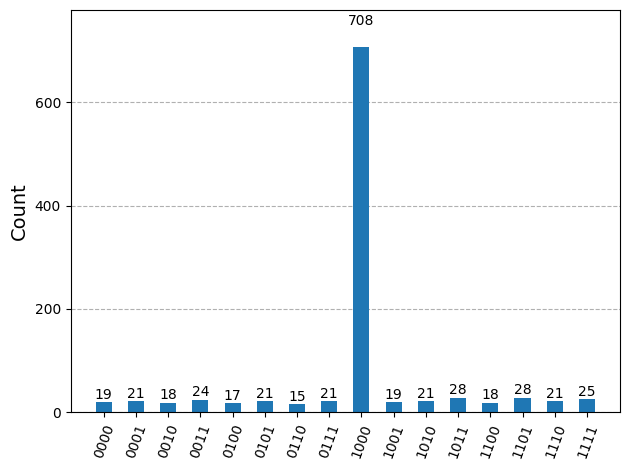

In [17]:
sim = AerSimulator()
job = sim.run(cq, shots = 1024)
results = job.result()
answer = results.get_counts()
print(answer)
print(plot_histogram(answer))

In [18]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit import transpile

In [21]:
fake_backend = FakeBrisbane()
sim_fake = AerSimulator.from_backend(fake_backend)
fake_result = sim_fake.run(transpile(cq,sim_fake)).result()
fake_ans = fake_result.get_counts()
print(fake_ans)

{'0000': 64, '1001': 63, '0101': 69, '1110': 74, '0001': 60, '1111': 63, '1011': 59, '0011': 63, '0111': 62, '1100': 61, '0110': 53, '1000': 64, '1010': 72, '1101': 69, '0100': 67, '0010': 61}


Figure(640x480)


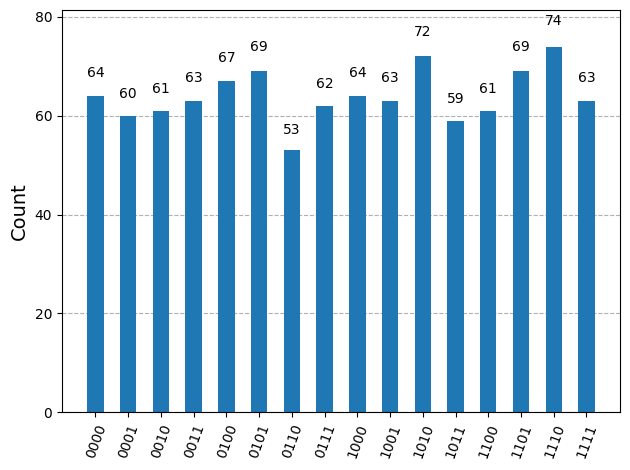

In [23]:
print(plot_histogram(fake_ans))